<a href="https://colab.research.google.com/github/Sylvariane/prediction_revenus/blob/main/P07_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prédiction de revenus

In [1]:
# connexion à Google Drive pour importer les dossiers
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_context('talk')
sns.set_palette('Set1')

In [4]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def lorenz_curve(X):
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[10,10])
    ## scatter plot of Lorenz curve
    _ = ax.plot(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='red', label=i)
    _ = ax.plot([0,1], [0,1], color='k', label='bissectrice')
    _ = plt.title('Courbe de Lorenz de ' + i)
    _ = plt.legend()
    _ = plt.show()

In [5]:
data = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/data-projet7.csv')

In [6]:
data.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


**Mission 1**


Résumez les données utilisées :
- Année(s) des données utilisées ;
- Nombre de pays présents ;
- Population couverte par l'analyse (en termes de pourcentage de la population mondiale).


Les données de la World Income Distribution présentent pour chaque pays les quantiles de la distribution des revenus de leur population respective.
- De quel type de quantiles s'agit-il (quartiles, déciles, etc.) ?
- Échantillonner une population en utilisant des quantiles est-il selon vous une bonne méthode ? Pourquoi ?

Nous appellerons ici chaque quantile une classe de revenu.
Ainsi, la valeur de la colonne income pour un quantile donné peut être vue comme le revenu moyen des personnes appartenant à la classe de revenu correspondante à ce quantile.


L'unité utilisée dans la colonne income de la world income distribution est le $PPP. Cette unité est calculée par la Banque mondiale, selon la méthode Eltöte-Köves-Szulc. Après vous être documenté, vous expliquerez à votre mentor très brièvement à quoi correspond cette unité et pourquoi elle est pertinente pour une comparaison de pays différents.

In [7]:
year_survey = data['year_survey'].unique()
print(np.sort(year_survey))

[2004 2006 2007 2008 2009 2010 2011]


Les années présentées dans l'échantillon sont 2004, 2006, 2007, 2008, 2009, 2010 et 2011.

In [8]:
country = data['country'].unique()
print('Nombre de pays présents dans l\'échantillon : ', len(country))

Nombre de pays présents dans l'échantillon :  116


In [9]:
country_iso = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/sql-pays.csv', header=None)

In [10]:
country_iso.columns = ['0', '1', '2', 'Code ISO', 'Pays', '5']
country_iso = country_iso[['Code ISO', 'Pays']]

In [11]:
data = pd.merge(data, country_iso, left_on='country', right_on='Code ISO')
data = data[['Code ISO', 'Pays', 'year_survey', 'quantile', 'nb_quantiles', 'income', 'gdpppp']]
data.head()

,Code ISO,Pays,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,Albanie,2008,1,100,"728,89795",7297
1,ALB,Albanie,2008,2,100,"916,66235",7297
2,ALB,Albanie,2008,3,100,"1010,916",7297
3,ALB,Albanie,2008,4,100,"1086,9078",7297
4,ALB,Albanie,2008,5,100,"1132,6997",7297


In [12]:
pop_fao = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/population_2008.csv')

In [13]:
pop_fao  = pop_fao[['Zone', 'Valeur']]
pop_fao['Valeur'] = pop_fao['Valeur'] * 1000
data = pd.merge(data, pop_fao, right_on='Zone', left_on='Pays')

In [14]:
pop_total = sum(pop_fao['Valeur'])
pop_data = data['Valeur'].groupby(data['Pays']).mean()
pourcent_pop_ech = round((pop_data.sum()/pop_total) * 100, 2)
print('Population couverte par l\'analyse : ' + str(pourcent_pop_ech) + '%.')

Population couverte par l'analyse : 84.14%.


In [15]:
# Suppression des dataframes non utiles à la suite de l'étude
del pop_fao
del country_iso

In [16]:
# Suppression des colonnes non utilisées dans la suite de l'étude
data = data.drop(columns=['Zone', 'Valeur'])

Pour chaque pays, les revenus sont présentés sous la forme de centiles. On dispose de 100 classes de revenus par pays. L'avantage de ce découpage permet de gommer les écarts entre les pays. De plus, on va avoir tendance à voir moins de valeurs qui vont être influencés par des valeurs aberrantes comme cela serait le cas pour une moyenne par exemple.

**Définition de méthode Eltöte-Köves-Szulc** : il s'agit d'une méthode statistique qui permet de calculer la parité de pouvoir d'achat. Elle a l'avantage de donner un poids à chaque pays et ainsi favoriser la comparaison entre différents pays.

**Mission 2**

- Montrez la diversité des pays en termes de distribution de revenus à l'aide d'un graphique. Celui-ci représentera le revenu moyen (axe des ordonnées, sur une échelle logarithmique) de chacune des classes de revenus (axe des abscisses) pour 5 à 10 pays que vous aurez choisis pour montrer la diversité des cas.
- Représentez la courbe de Lorenz de chacun des pays choisis.
- Pour chacun de ces pays, représentez l'évolution de l'indice de Gini au fil des ans.
- Classez les pays par indice de Gini. Donnez la moyenne, les 5 pays ayant l'indice de Gini le plus élevé et les 5 pays ayant l'indice de Gini le plus faible. En quelle position se trouve la France ?


In [17]:
# Choix de 10 pays pour la suite de l'analyse
data = data.set_index('Pays')
df = data.loc(axis=0)['France', 'Géorgie', 'Canada', 'Honduras', 'Colombie', 'Brésil', 'Albanie', 'Allemagne', 'Philippines', 'Thaïlande'].reset_index()
df = df.sort_values('Pays')
df.head()

,Pays,Code ISO,year_survey,quantile,nb_quantiles,income,gdpppp
651,Albanie,ALB,2008,52,100,"2545,9229",7297
672,Albanie,ALB,2008,73,100,"3390,7966",7297
671,Albanie,ALB,2008,72,100,"3341,487",7297
670,Albanie,ALB,2008,71,100,"3280,7761",7297
669,Albanie,ALB,2008,70,100,"3230,5708",7297


In [18]:
# modification de la classe de 'income'
# création de la classe 'income_log10'
df['income'] = df['income'].str.replace(',', ".")
df['income'] = df['income'].apply(lambda x: float(x))
df['income_log10'] = df['income'].apply(lambda x: math.log10(x)) 
df.head()

,Pays,Code ISO,year_survey,quantile,nb_quantiles,income,gdpppp,income_log10
651,Albanie,ALB,2008,52,100,2545.9229,7297,3.405845
672,Albanie,ALB,2008,73,100,3390.7966,7297,3.530302
671,Albanie,ALB,2008,72,100,3341.4870,7297,3.523940
670,Albanie,ALB,2008,71,100,3280.7761,7297,3.515977
669,Albanie,ALB,2008,70,100,3230.5708,7297,3.509279


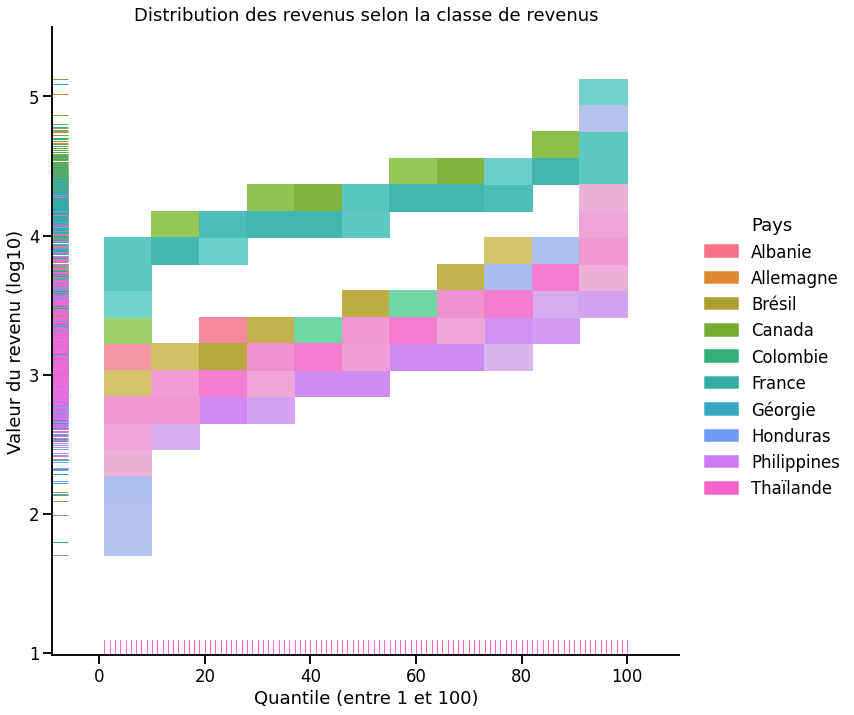

In [19]:
# Affichage de la distribution des revenus en fonction de la classe de revenus
_ = sns.displot(x='quantile', y='income_log10', hue='Pays', rug=True, height=10, data=df)
_ = plt.title('Distribution des revenus selon la classe de revenus')
_ = plt.xlabel('Quantile (entre 1 et 100)')
_ = plt.ylabel('Valeur du revenu (log10)')
_ = plt.show()

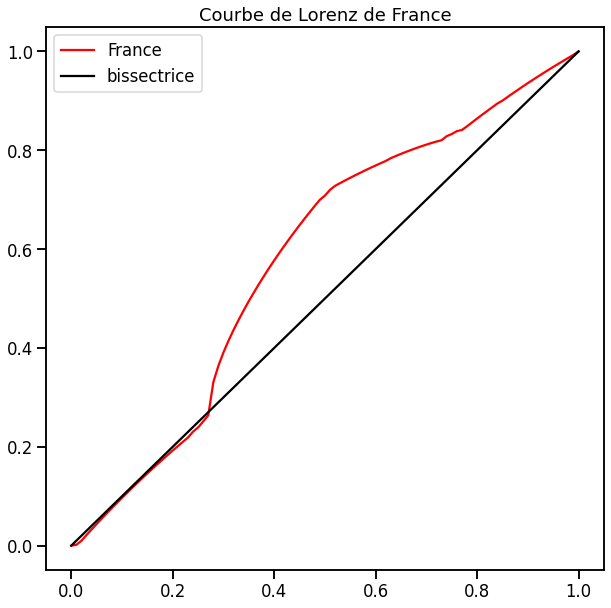

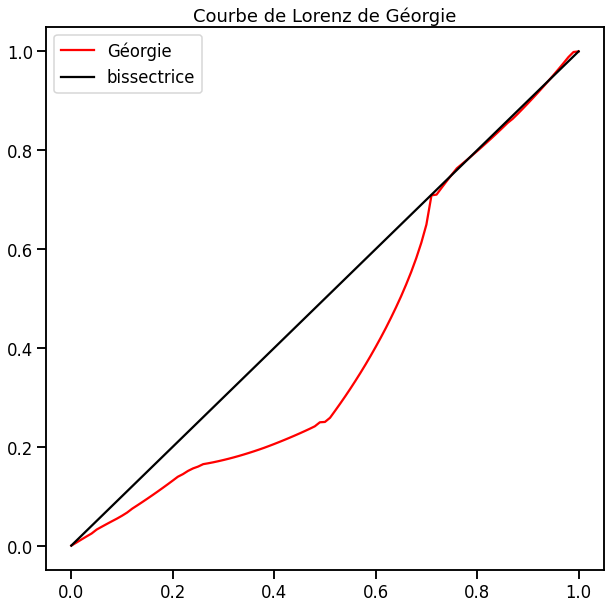

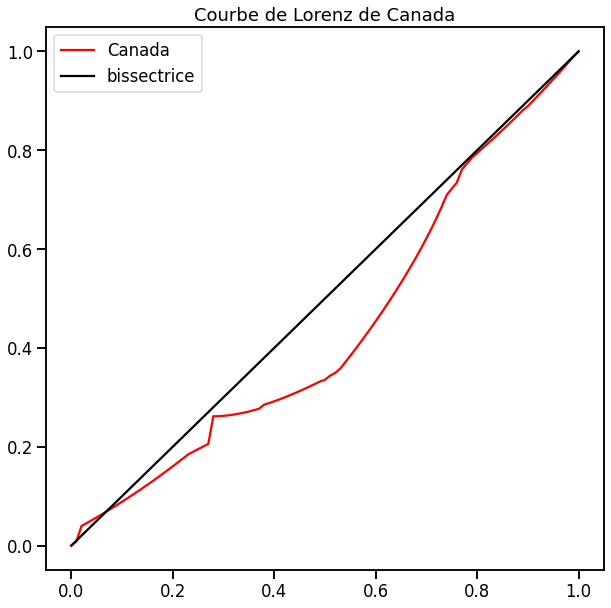

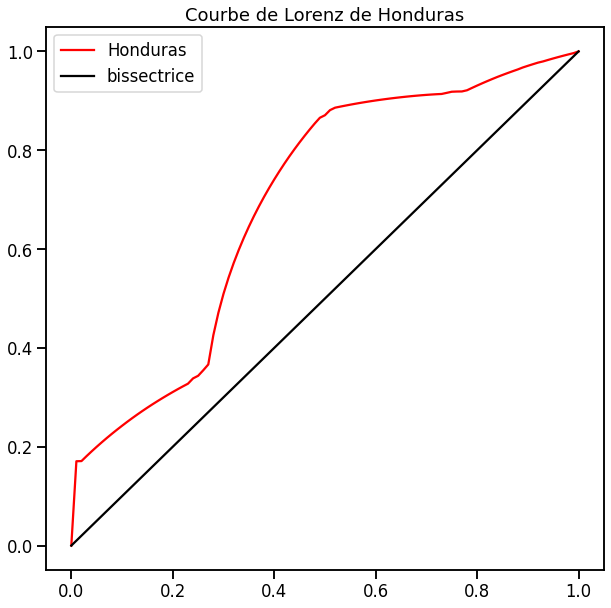

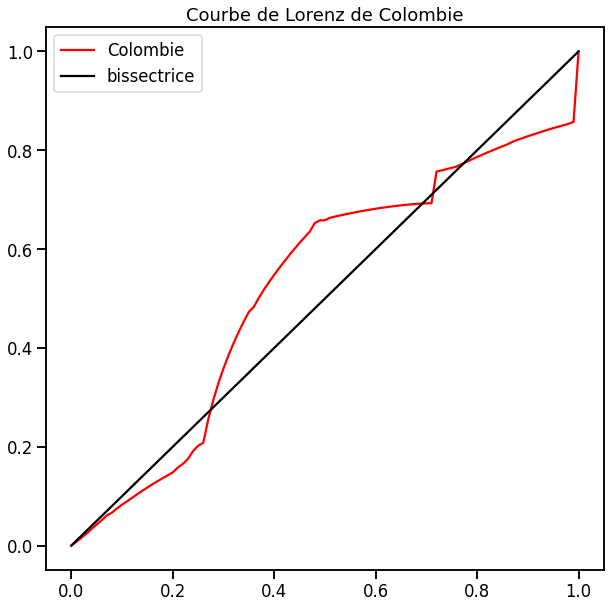

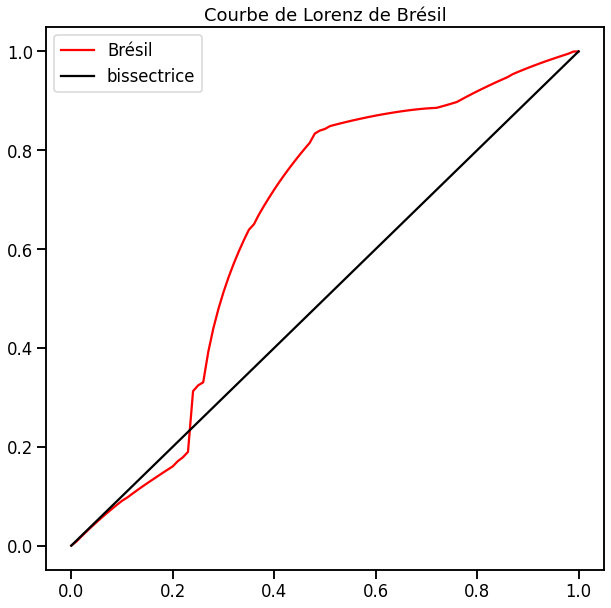

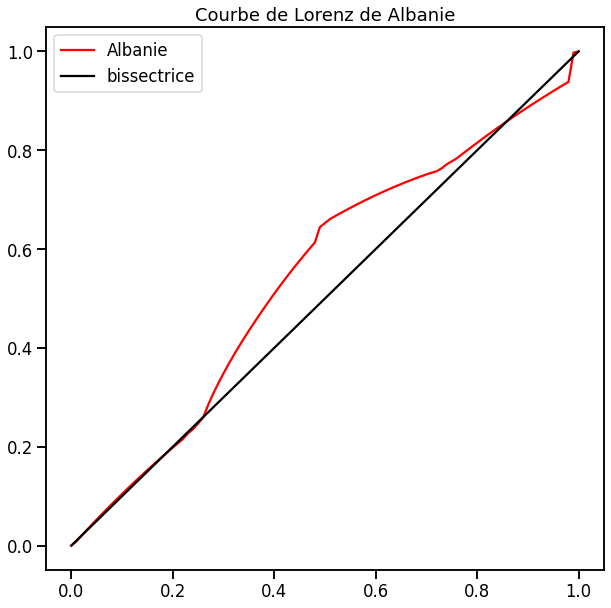

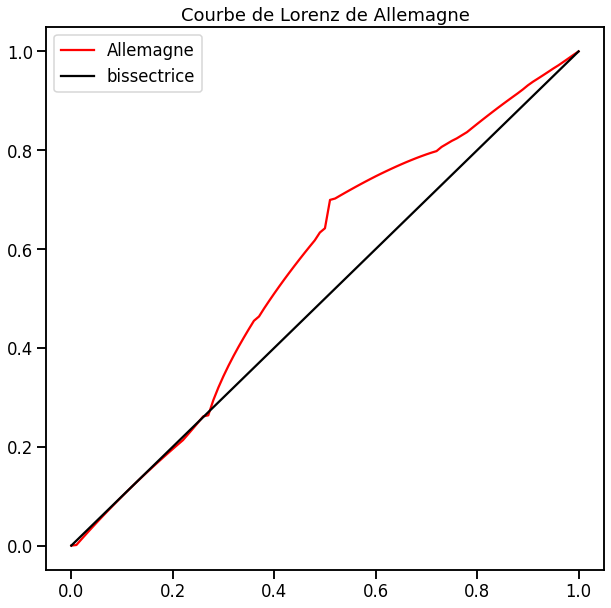

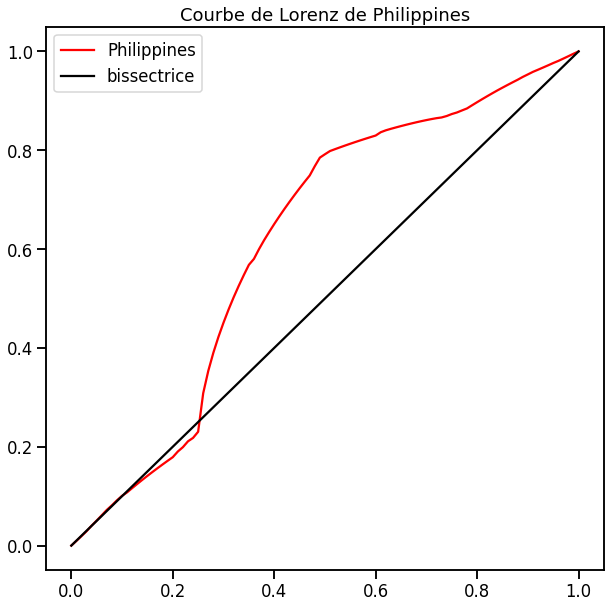

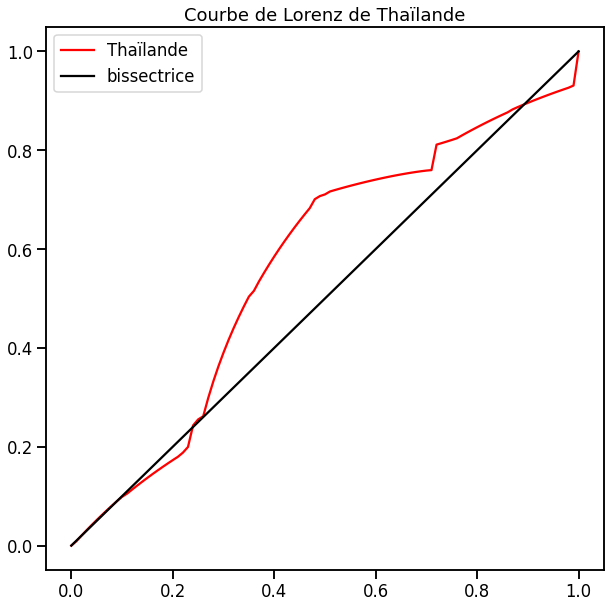

In [20]:
pays = ['France', 'Géorgie', 'Canada', 'Honduras', 'Colombie', 'Brésil', 'Albanie', 'Allemagne', 'Philippines', 'Thaïlande']

for i in pays:
  arr = df.loc[df['Pays'] == i]['income']
  X = np.array(arr)
  lorenz_curve(X)

In [21]:
gini_index = pd.read_csv('/content/drive/My Drive/Data Analyst - OC/Projets/P7_guillot_cecile/gini_index.csv', sep=',')

In [22]:
gini_index = gini_index.set_index('Country Name')
gini_index = gini_index.loc(axis=0)['France', 'Georgia', 'Canada', 'Honduras', 'Colombia', 'Brazil', 'Philippines', 'Thailand', 'Germany', 'Albania']

In [23]:
gini_index = gini_index[['2004', '2006', '2007', '2008', '2009', '2010','2011']]
gini_index.head()

,2004,2006,2007,2008,2009,2010,2011
Country Name,,,,,,,
France,30.6,29.7,32.4,33.0,32.7,33.7,33.3
Georgia,36.2,36.9,38.1,38.5,38.2,39.5,39.6
Canada,33.7,NaN,33.8,NaN,NaN,33.6,NaN
Honduras,58.1,57.5,55.8,55.5,51.3,53.1,56.2
Colombia,54.8,NaN,NaN,55.5,54.4,54.7,53.5


In [24]:
gini_index = gini_index.T

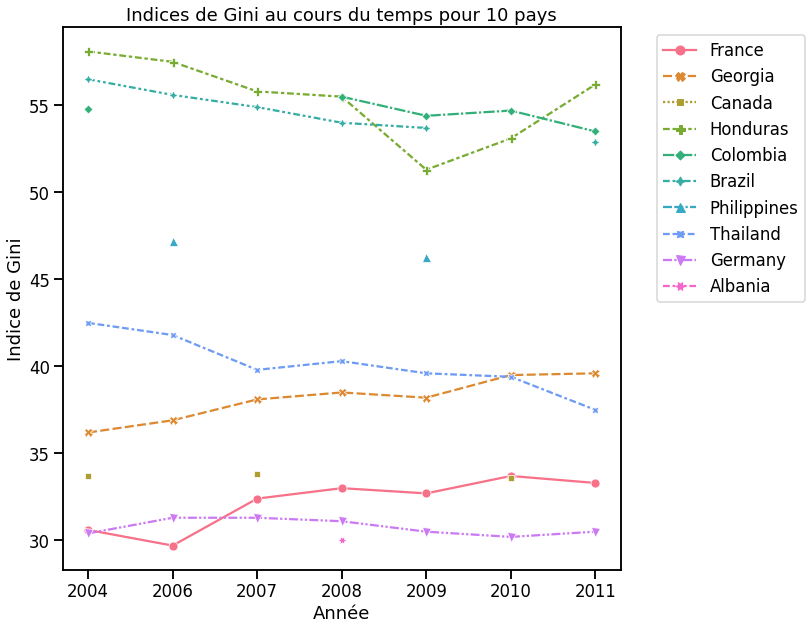

In [25]:
_ = plt.figure(figsize=(10,10))
_ = sns.lineplot(data=gini_index, markers=True)
_ = plt.title('Indices de Gini au cours du temps pour 10 pays')
_ = plt.xlabel('Année')
_ = plt.ylabel('Indice de Gini')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

_ = plt.show()

In [28]:
gini_index.describe()

Country Name,France,Georgia,Canada,Honduras,Colombia,Brazil,Philippines,Thailand,Germany,Albania
count,7.00000,7.000000,3.00,7.000000,5.000000,6.000000,2.000000,7.000000,7.000000,1.0
mean,32.20000,38.142857,33.70,55.357143,54.580000,54.600000,46.750000,40.128571,30.757143,30.0
std,1.48324,1.252806,0.10,2.401289,0.725948,1.323631,0.636396,1.646931,0.461364,NaN
min,29.70000,36.200000,33.60,51.300000,53.500000,52.900000,46.300000,37.500000,30.200000,30.0
25%,31.50000,37.500000,33.65,54.300000,54.400000,53.775000,46.525000,39.500000,30.450000,30.0
50%,32.70000,38.200000,33.70,55.800000,54.700000,54.450000,46.750000,39.800000,30.500000,30.0
75%,33.15000,39.000000,33.75,56.850000,54.800000,55.425000,46.975000,41.050000,31.200000,30.0
max,33.70000,39.600000,33.80,58.100000,55.500000,56.500000,47.200000,42.500000,31.300000,30.0


Classement du plus petit au plus grand : Albanie, Allemagne, France, Canada, Georgie, Thaïlande, Philippines, Colombie, Honduras et Brésil.

La France fait partie des pays ayant l'indice de Gini le moins élevé ce qui montre une répartition de la richesse plutôt égale pour ce pays. 

**Mission 3** : Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :
- le revenu moyen du pays
- l'indice de Gini du pays

Il nous manque donc, pour un individu : la classe de revenu de ses parents.

Pour chaque pays, nous allons utiliser une génération aléatoire de la classe de revenu des parents, à partir de ces seules deux informations :
- rho
- la classe de revenu de l'enfant.


1. Générez un grand nombre \(n\) de réalisations d'une variable que nous appellerons  \(ln(Y_{parent})\) selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. \(n\) doit être supérieur à 1000 fois le nombre de quantiles.
2. Générez \(n\) réalisations du terme d'erreur \(\epsilon\) selon une loi normale de moyenne 0 et d'écart type 1.
3. Pour une valeur donnée de \(\rho_j\) (par exemple 0.9), calculez \(y_{child} = e^{\alpha+\rho_jln(y_{parent})+\epsilon}\) . Le choix de \( \alpha\) n'a aucune incidence sur le résultat final et peut être supprimé. À ce stade, \(y_{child}\) contient des valeurs dont l'ordre de grandeur ne reflète pas la réalité, mais cela n'a pas d'influence pour la suite.
4. Pour chacun des \(n\) individus générés, calculez la classe de revenu  \(c_{i,child}\) ainsi que la classe de revenu de ses parents \(c_{i,parent}\) , à partir de \(y_{child}\) et \(y_{parent}\).
5. À partir de cette dernière information, estimez pour chaque  \(c_{i,child}\) la distribution conditionnelle de \(c_{i,parent}\) . Par exemple, si vous observez 6 individus ayant à la fois  \(c_{i,child} = 5\) et \(c_{i,parent} = 8\) , et que 200 individus sur 20000 ont \( c_{i,child} = 5\) , alors la probabilité d'avoir \( c_{i,parent} = 8\) sachant  \(c_{i,child} = 5\) et sachant \(\rho_j=0.9\) sera estimée à 6/200 (On note cette probabilité comme ceci : \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\)). Si votre population est divisée en \(c\) classes de revenu, vous devriez alors avoir \(c^2\) estimations de ces probabilités conditionnelles, pour chaque pays.
6. Optionnellement et pour vérifier la cohérence de votre code, vous pouvez créer un graphique représentant ces distributions conditionnelles. Voici 2 exemples pour une population segmentée en 10 classes, pour 2 valeurs de \(\rho_j\) : l'une traduisant une forte mobilité (0.1) et l'autre une très faible mobilité (0.9).
7. Éventuellement et pour éviter toute confusion, effacez les individus que vous venez de générer (nous n'en avons plus besoin), et ne gardez que les distributions conditionnelles.
8. Nous allons maintenant travailler sur un nouvel échantillon. Celui-ci sera créé à partir de la WID. Pour chaque individu de la World Income Distribution, créez-en 499 "clones". La taille de votre nouvel échantillon sera donc 500 fois plus grand que celui de la World Income Distribution.
9. Pour chaque \(c_{i,child}\) et chaque pays, il y a maintenant 500 individus. Vous attribuerez aux 500 individus leurs classes \( c_{i,parent}\) conformément aux distributions trouvées précédemment. Par exemple, si \(P(c_{i,parent}=8|c_{i,child}=5,\rho_j=0.9) = 0.03\) , alors vous assignerez la classe \(c_{i,parent} = 8\) à 15 des 500 individus du pays \( j\) ayant \(c_{i,child}=5\) , car 500*0.03 = 15.
11. Éventuellement et pour éviter toute confusion, effacez la variable \(c_{i,child}\)  : nous n'en avons pas besoin pour la mission 4.
12. Assurez-vous que votre nouvel échantillon contiennent bien les variables initialement présentes dans la World Income Distribution : \(m_j\) et \(G_j\) .

Utilisez ce nouvel échantillon pour la mission 4.

In [ ]:
import scipy.stats as st

import pandas as pd

import numpy as np

from collections import Counter


def generate_incomes(n, pj):

    # On génère les revenus des parents (exprimés en logs) selon une loi normale.

    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)

    ln_y_parent = st.norm(0,1).rvs(size=n)

    # Génération d'une réalisation du terme d'erreur epsilon

    residues = st.norm(0,1).rvs(size=n)

    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

    

def quantiles(l, nb_quantiles):

    size = len(l)

    l_sorted = l.copy()

    l_sorted = l_sorted.sort_values()

    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)

    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}

    return pd.Series([q_dict[e] for e in l])


def compute_quantiles(y_child, y_parents, nb_quantiles):

    y_child = pd.Series(y_child)

    y_parents = pd.Series(y_parents)

    c_i_child = quantiles(y_child, nb_quantiles)

    c_i_parent = quantiles(y_parents, nb_quantiles)

    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)

    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]

    return sample


def distribution(counts, nb_quantiles):

    distrib = []

    total = counts["counts"].sum()

    

    if total == 0 :

        return [0] * nb_quantiles

    

    for q_p in range(1, nb_quantiles+1):

        subset = counts[counts.c_i_parent == q_p]

        if len(subset):

            nb = subset["counts"].values[0]

            distrib += [nb / total]

        else:

            distrib += [0]

    return distrib   


def conditional_distributions(sample, nb_quantiles):

    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)

    counts = counts.reset_index()

    counts.columns = ["c_i_child","c_i_parent","counts"]

    

    mat = []

    for child_quantile in np.arange(nb_quantiles)+1:

        subset = counts[counts.c_i_child == child_quantile]

        mat += [distribution(subset, nb_quantiles)]

    return np.array(mat) 


def plot_conditional_distributions(p, cd, nb_quantiles):

    plt.figure()

    

    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

    cumul = np.array([0] * nb_quantiles)

    

    for i, child_quantile in enumerate(cd):

        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")

        cumul = cumul + np.array(child_quantile)


    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])

    plt.title("p=" + str(p))

    plt.legend()

    plt.xlabel("quantile parents")

    plt.ylabel("probabilité du quantile enfant")

    plt.show()

    

def proba_cond(c_i_parent, c_i_child, mat):

    return mat[c_i_child, c_i_parent]


pj = 0.9                 # coefficient d'élasticité du pays j

nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)

n  = 1000*nb_quantiles   # taille de l'échantillon


y_child, y_parents = generate_incomes(n, pj)

sample = compute_quantiles(y_child, y_parents, nb_quantiles)

cd = conditional_distributions(sample, nb_quantiles)

#plot_conditional_distributions(pj, cd, nb_quantiles) # Cette instruction prendra du temps si nb_quantiles > 10

print(cd)


c_i_child = 5 

c_i_parent = 8

p = proba_cond(c_i_parent, c_i_child, cd)

print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

**Mission 4** : Nous chercherons à expliquer le revenu des individus en fonction de plusieurs variables explicatives : le pays de l'individu, l'indice de Gini de ce pays, la classe de revenus des parents, etc.

Appliquez une ANOVA sur vos données, en n’incluant comme variable explicative que le pays de l’individu. Analysez la performance du modèle.

Appliquez une régression linéaire sur vos données, en incluant comme variables explicatives uniquement le revenu moyen du pays de l’individu et l’indice de Gini du pays de l’individu. Quel est le pourcentage de variance expliquée par votre modèle ?

Selon ce modèle, donnez la décomposition de variance totale expliquée par :
- Le pays de naissance (ie. le revenu moyen et l’indice de Gini) ;
- Les autres facteurs non considérés dans le modèle (efforts, chance, etc.).

Améliorez le modèle précédent en incluant maintenant la classe de revenu des parents. Quel est le pourcentage de variance expliquée par ce nouveau modèle ?

Selon ce dernier modèle, donnez la décomposition de variance totale expliquée par :
- Le pays de naissance et le revenu des parents
- Les autres facteurs non considérés dans le modèle (efforts, chance, etc.)
